### testing out setting up a mongo database

#### tutorial: http://api.mongodb.com/python/current/tutorial.html

In [279]:
import json
from pymongo import MongoClient
import pymongo
import datetime
from datetime import timedelta
import os
import pprint
import pandas as pd
import requests
import urllib
from bs4 import BeautifulSoup

In [280]:
# data we'll be adding to a test DB:

# single shop example:
fname = '/Users/kylefrankovich/Desktop/insight/list_test_data/deluxetattoochicago/deluxetattoochicago.json'
data = json.load(open(fname))
len(data)

20

In [278]:
data[0]

NameError: name 'data' is not defined

### make connection with MongoClient:

In [281]:
# client = MongoClient() # connects to default host and port, can also manually specify:
client = MongoClient('localhost', 27017)

### creating database:

A single instance of MongoDB can support multiple independent databases. When working with PyMongo you access databases using attribute style access on MongoClient instances:

In [9]:
db = client.test_database

### creating a collection:

A collection is a group of documents stored in MongoDB, and can be thought of as roughly the equivalent of a table in a relational database. Getting a collection in PyMongo works the same as getting a database:

In [10]:
collection = db.test_collection

In [25]:
# datetime with a certain range: https://stackoverflow.com/questions/4695609/checking-date-against-date-range-in-python

now = datetime.datetime.now()
now
then = datetime.datetime.now() - timedelta(days=4)
then
print(then.date())

2018-01-18


In [32]:
account_name = 'deluxetattoochicago'
insta_url = 'https://www.instagram.com/p/'
account_name
temp_dict = {}
temp_dict['account'] = account_name
temp_dict['URL'] = data[0]['display_url']
temp_dict['link_to_post'] = insta_url + data[0]['shortcode']
temp_dict['likes'] = data[0]['edge_media_preview_like']['count']
temp_dict['date_added'] = then
temp_dict['contains_tattoo'] = 1
temp_dict

{'URL': 'https://scontent-atl3-1.cdninstagram.com/vp/7871e551e9177d2c35ec382de74dd080/5AF7EE27/t51.2885-15/e35/26284607_178071299611229_5893020074452713472_n.jpg',
 'account': 'deluxetattoochicago',
 'contains_tattoo': 1,
 'date_added': datetime.datetime(2018, 1, 18, 13, 21, 45, 899653),
 'likes': 185,
 'link_to_post': 'https://www.instagram.com/p/BeBwOoND4Cc'}

In [34]:
post = {"author": "Mike",
...         "text": "My first blog post!",
...         "tags": ["mongodb", "python", "pymongo"],
...         "date": datetime.datetime.utcnow()}
post

{'author': 'Mike',
 'date': datetime.datetime(2018, 1, 22, 19, 27, 32, 46113),
 'tags': ['mongodb', 'python', 'pymongo'],
 'text': 'My first blog post!'}

In [36]:
# set up a test collection to insert test data:

In [35]:
test_collection = db.test_collection

In [38]:
# insert a test post:
test_collection.insert_one(temp_dict)

In [282]:
# listing all of the collections in our database:

db.collection_names(include_system_collections=False)

['gram_posts', 'posts']

In [41]:
# getting a single document:

pprint.pprint(test_collection.find_one())

{'URL': 'https://scontent-atl3-1.cdninstagram.com/vp/7871e551e9177d2c35ec382de74dd080/5AF7EE27/t51.2885-15/e35/26284607_178071299611229_5893020074452713472_n.jpg',
 '_id': ObjectId('5a663cf7fce11d1e9428e791'),
 'account': 'deluxetattoochicago',
 'contains_tattoo': 1,
 'date_added': datetime.datetime(2018, 1, 18, 13, 21, 45, 899000),
 'likes': 185,
 'link_to_post': 'https://www.instagram.com/p/BeBwOoND4Cc'}


In [42]:
test_collection.count()

1

In [84]:
# code for looping through shop/artist posts, add to database

rootdir = '/Users/kylefrankovich/Desktop/insight/list_test_data'

rows_list = []
insta_url = 'https://www.instagram.com/p/'

current_date = datetime.datetime.now()

for root, dirs, files in os.walk(rootdir):
    for file in files:
        if file.endswith('.json'):
            current_account_data = json.load(open(os.path.join(root, file))) # load current account .json (shop or artist)
            account_name = os.path.basename(root)
            for post in current_account_data: # loop throough all posts for account
                temp_dict = {}
                temp_dict['account'] = account_name
                temp_dict['URL'] = post['display_url']
                temp_dict['link_to_post'] = insta_url + post['shortcode']
                temp_dict['likes'] = post['edge_media_preview_like']['count']
                temp_dict['owner_id'] = post['owner']['id']
                temp_dict['dimensions'] = post['dimensions']
                if 'tags' in post.keys():
                    temp_dict['tags'] = post['tags']
                else:
                    temp_dict['tags'] = []
                if post['edge_media_to_caption']['edges']:
                    temp_dict['caption'] = post['edge_media_to_caption']['edges'][0]['node']['text']
                else: 
                    temp_dict['caption'] = 'no caption'
                temp_dict['date_added'] = current_date
                temp_dict['contains_tattoo'] = 1 # need to update here with model when ready
                if collection.find({"URL": temp_dict['URL']}).count() == 0: # only add current post if not in database
                    collection.insert_one(temp_dict)

In [85]:
test_collection.count()

85

In [86]:
for post in test_collection.find():
    pprint.pprint(post)

{'URL': 'https://scontent-atl3-1.cdninstagram.com/vp/7871e551e9177d2c35ec382de74dd080/5AF7EE27/t51.2885-15/e35/26284607_178071299611229_5893020074452713472_n.jpg',
 '_id': ObjectId('5a663cf7fce11d1e9428e791'),
 'account': 'deluxetattoochicago',
 'contains_tattoo': 1,
 'date_added': datetime.datetime(2018, 1, 18, 13, 21, 45, 899000),
 'likes': 185,
 'link_to_post': 'https://www.instagram.com/p/BeBwOoND4Cc'}
{'URL': 'https://scontent-atl3-1.cdninstagram.com/vp/7871e551e9177d2c35ec382de74dd080/5AF7EE27/t51.2885-15/e35/26284607_178071299611229_5893020074452713472_n.jpg',
 '_id': ObjectId('5a663ee4fce11d1e9428e792'),
 'account': 'deluxetattoochicago',
 'contains_tattoo': 1,
 'date_added': datetime.datetime(2018, 1, 18, 13, 21, 45, 899000),
 'likes': 185,
 'link_to_post': 'https://www.instagram.com/p/BeBwOoND4Cc'}
{'URL': 'https://scontent-atl3-1.cdninstagram.com/vp/e32bc058804e635bcaab86fed63a32a7/5AE5E8DC/t51.2885-15/e35/26066203_1973289282700532_7567894987308793856_n.jpg',
 '_id': ObjectI

In [47]:
test_collection.find({"account": "deluxetattoochicago"}).count()

21

### test out updating the account posts with instagram-scraper, then update the database:

instagram-scraper --filename /Users/kylefrankovich/Desktop/insight/chicago_short_shop_list.txt --maximum 10 --media-types image --include-location --destination /Users/kylefrankovich/Desktop/insight/list_test_data --latest --retain-username

#### search on 1/22 had no updates for deluxe, but had 4 new posts for insightstudios; raises new issue, need to check to see if post is in database before adding it:

In [63]:
blah = test_collection.find({"URL": feral_url})
test_collection.find({"URL": data[1]['display_url']}).count()
if test_collection.find({"URL": feral_url}).count() == 0:
    print('URL not in database, add it')

In [52]:
feral_url = 'https://scontent-atl3-1.cdninstagram.com/vp/28607fb4ca62fc1cfe265fecffd76904/5AE6B6C4/t51.2885-15/e35/26066485_169583613655603_4826747482048299008_n.jpg'

data[0]['display_url']

'https://scontent-atl3-1.cdninstagram.com/vp/7871e551e9177d2c35ec382de74dd080/5AF7EE27/t51.2885-15/e35/26284607_178071299611229_5893020074452713472_n.jpg'

### added another shop (chicagoinktattoo); should theoretically add new folder, not update deluxe and insight studios, and then updating the database should only add the new posts from new shop:

instagram-scraper --filename /Users/kylefrankovich/Desktop/insight/chicago_short_shop_list.txt --maximum 10 --media-types image --include-location --destination /Users/kylefrankovich/Desktop/insight/list_test_data --latest --retain-username

added 8 postst from chicagoink; previous database entries: 65; should now be 65+8 = 73

### updated mongo database through python script (update_mongo_database.py); 

added the following database and collections:

db = client.insight_database
collection = db.posts

In [283]:
# creating/opening database:
db = client.insight_database

# opening collection (instagram posts):
collection = db.posts

In [284]:
# listing all of the collections in our database:

db.collection_names(include_system_collections=False)

['gram_posts', 'posts']

In [285]:
gram_collection = db.gram_posts
print(gram_collection.count())

2043


In [85]:
gram_collection.find_one({"account": "deluxetattoochicago"})['link_to_post']
gram_collection.find_one({"account": "deluxetattoochicago"})

{'URL': 'https://scontent-atl3-1.cdninstagram.com/vp/7871e551e9177d2c35ec382de74dd080/5AF7EE27/t51.2885-15/e35/26284607_178071299611229_5893020074452713472_n.jpg',
 '_id': ObjectId('5a695fe8fce11d837b08b764'),
 'account': 'deluxetattoochicago',
 'caption': 'Tattoo done by Bunny. #bunnydontinstagram #deluxetattoochicago',
 'contains_tattoo': 1,
 'date_added': datetime.datetime(2018, 1, 24, 22, 40, 49, 35000),
 'dimensions': {'height': 1350, 'width': 1080},
 'likes': 192,
 'link_to_post': 'https://www.instagram.com/p/BeBwOoND4Cc',
 'owner_id': '253694160',
 'tags': ['bunnydontinstagram', 'deluxetattoochicago']}

In [ ]:
<blockquote class="instagram-media" data-instgrm-captioned data-instgrm-permalink="https://www.instagram.com/p/BeBwOoND4Cc/" data-instgrm-version="8" style=" background:#FFF; border:0; border-radius:3px; box-shadow:0 0 1px 0 rgba(0,0,0,0.5),0 1px 10px 0 rgba(0,0,0,0.15); margin: 1px; max-width:658px; padding:0; width:99.375%; width:-webkit-calc(100% - 2px); width:calc(100% - 2px);"><div style="padding:8px;"> <div style=" background:#F8F8F8; line-height:0; margin-top:40px; padding:62.5% 0; text-align:center; width:100%;"> <div style=" background:url(data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAACwAAAAsCAMAAAApWqozAAAABGdBTUEAALGPC/xhBQAAAAFzUkdCAK7OHOkAAAAMUExURczMzPf399fX1+bm5mzY9AMAAADiSURBVDjLvZXbEsMgCES5/P8/t9FuRVCRmU73JWlzosgSIIZURCjo/ad+EQJJB4Hv8BFt+IDpQoCx1wjOSBFhh2XssxEIYn3ulI/6MNReE07UIWJEv8UEOWDS88LY97kqyTliJKKtuYBbruAyVh5wOHiXmpi5we58Ek028czwyuQdLKPG1Bkb4NnM+VeAnfHqn1k4+GPT6uGQcvu2h2OVuIf/gWUFyy8OWEpdyZSa3aVCqpVoVvzZZ2VTnn2wU8qzVjDDetO90GSy9mVLqtgYSy231MxrY6I2gGqjrTY0L8fxCxfCBbhWrsYYAAAAAElFTkSuQmCC); display:block; height:44px; margin:0 auto -44px; position:relative; top:-22px; width:44px;"></div></div> <p style=" margin:8px 0 0 0; padding:0 4px;"> <a href="https://www.instagram.com/p/BeBwOoND4Cc/" style=" color:#000; font-family:Arial,sans-serif; font-size:14px; font-style:normal; font-weight:normal; line-height:17px; text-decoration:none; word-wrap:break-word;" target="_blank">Tattoo done by Bunny. #bunnydontinstagram #deluxetattoochicago</a></p> <p style=" color:#c9c8cd; font-family:Arial,sans-serif; font-size:14px; line-height:17px; margin-bottom:0; margin-top:8px; overflow:hidden; padding:8px 0 7px; text-align:center; text-overflow:ellipsis; white-space:nowrap;">A post shared by <a href="https://www.instagram.com/deluxetattoochicago/" style=" color:#c9c8cd; font-family:Arial,sans-serif; font-size:14px; font-style:normal; font-weight:normal; line-height:17px;" target="_blank"> Deluxe Tattoo</a> (@deluxetattoochicago) on <time style=" font-family:Arial,sans-serif; font-size:14px; line-height:17px;" datetime="2018-01-16T22:38:44+00:00">Jan 16, 2018 at 2:38pm PST</time></p></div></blockquote> <script async defer src="//platform.instagram.com/en_US/embeds.js"></script>

In [286]:
collection.count()

2240

### update database w/ model classification:

In [ ]:
rootdir = '/Users/kylefrankovich/Desktop/insight_project_data'
for root, dirs, files in os.walk(rootdir):
    for file in files:
        if file.endswith('.json'):
            current_account_data = json.load(open(os.path.join(root, file))) # load current account .json (shop or artist)
            account_name = os.path.basename(root)
            for post in current_account_data: # loop throough all posts for account
                temp_dict = {}
                current_url = post['display_url']
                
                
#                 temp_dict['account'] = account_name
                
#                 temp_dict['account'] = account_name
#                 temp_dict['URL'] = post['display_url']
#                 temp_dict['link_to_post'] = insta_url + post['shortcode']
#                 temp_dict['likes'] = post['edge_media_preview_like']['count']
#                 temp_dict['owner_id'] = post['owner']['id']
#                 temp_dict['dimensions'] = post['dimensions']
#                 if 'tags' in post.keys():
#                     temp_dict['tags'] = post['tags']
#                 else:
#                     temp_dict['tags'] = []
#                 if post['edge_media_to_caption']['edges']:
#                     temp_dict['caption'] = post['edge_media_to_caption']['edges'][0]['node']['text']
#                 else:
#                     temp_dict['caption'] = 'no caption'
#                 temp_dict['date_added'] = current_date
#                 temp_dict['contains_tattoo'] = 1 # need to update here with model when ready
#                 if collection.find({"URL": temp_dict['URL']}).count() == 0: # only add current post if not in database
#                     collection.insert_one(temp_dict)

In [287]:
gram_collection.find({"account": "deluxetattoochicago"}).count()

10

In [288]:
gram_collection.find_one({"account": "deluxetattoochicago"})['date_added']
# (d.year, d.month, d.day) >= (search_date.year,search_date.month,search_date.day)

datetime.datetime(2018, 1, 24, 22, 40, 49, 35000)

In [136]:
dt1 = datetime.datetime(2011, 3, 3, 11, 12)
day = datetime.date(2011, 3, 2)
dt2 = datetime.datetime.combine(day, datetime.time(0, 0))
print(day)
print(dt2)
date1 = datetime.datetime.strptime("18/01/13 18:30", "%d/%m/%y %H:%M")
print(date1)

2011-03-02
2011-03-02 00:00:00


TypeError: an integer is required (got type str)

In [296]:
today = datetime.date.today()
margin = datetime.timedelta(days = 7)

search_date = today - margin
print('search date:', search_date)
# today - margin <= datetime.date(2018, 1, 18)

# gram_collection.find({'date_added':{"$gt":search_date}}).count()

# today - margin <= datetime.date(2011, 1, 15) <= today + margin

# gram_collection.find_one({"account": "deluxetattoochicago"})['date_added']

search date: 2018-01-22


In [289]:
# sort posts by number of likes, and only return posts that contain a tattoo:


sorted_posts = gram_collection.find({"contains_tattoo": 1}).sort([("likes", pymongo.DESCENDING)])

In [290]:
df =  pd.DataFrame(list(sorted_posts))

In [291]:
df.head(30)

,URL,_id,account,caption,contains_tattoo,date_added,dimensions,likes,link_to_post,owner_id,tags
0,https://scontent-atl3-1.cdninstagram.com/vp/b5...,5a69ef7efce11d89aa6cafe1,outofstepbooks,Incredible placement and execution on this #sn...,1,2018-01-25 08:50:24.318,"{'height': 1080, 'width': 1080}",13332,https://www.instagram.com/p/BeB56DIFm_j,426668379,"[tattooed, reptiles, dinosaurs, book, tattoo, ..."
1,https://scontent-atl3-1.cdninstagram.com/vp/96...,5a69fc4ffce11d89aa6cb5e8,tattoosnob,Pixelated Nipples by @self135 at Alchemist Tat...,1,2018-01-25 08:50:24.318,"{'height': 1080, 'width': 1080}",11018,https://www.instagram.com/p/BeEpHLlnYI0,52723390,"[alchemisttattoo, tattoos, self135, pixels, ta..."
2,https://scontent-atl3-1.cdninstagram.com/vp/69...,5a69f944fce11d89aa6cb46d,sullentv,#HumpDay vibes with @teneile_napoli!\n#sullent...,1,2018-01-25 08:50:24.318,"{'height': 1350, 'width': 1080}",10453,https://www.instagram.com/p/BeEeyggD9YO,202608559,"[sullenangels, sullenclothing, sullenfamily, t..."
3,https://scontent-atl3-1.cdninstagram.com/vp/b1...,5a69f780fce11d89aa6cb3a1,katietattoos,In honor of the Ink Master season 9 finale re-...,1,2018-01-25 08:50:24.318,"{'height': 1349, 'width': 1080}",8256,https://www.instagram.com/p/BdwMwOkHDFD,7833547,"[loveyall, flowerlove, ladytattooers, thankyou..."
4,https://scontent-atl3-1.cdninstagram.com/vp/28...,5a69f52afce11d89aa6cb284,feralcatbox,The feeling when you’re nearing the end of a b...,1,2018-01-25 08:50:24.318,"{'height': 1080, 'width': 1080}",8208,https://www.instagram.com/p/BdwDISqH76O,13743730,[]
5,https://scontent-atl3-1.cdninstagram.com/vp/35...,5a69ef87fce11d89aa6cafe5,outofstepbooks,We love this cool #castle #skull #illustration...,1,2018-01-25 08:50:24.318,"{'height': 1080, 'width': 1080}",8065,https://www.instagram.com/p/Bd8TyNPlz8L,426668379,"[books, book, artistic, skull, illustration, c..."
6,https://scontent-atl3-1.cdninstagram.com/vp/2e...,5a69fc53fce11d89aa6cb5ea,tattoosnob,Rose Band by @chris_tattooer at @mothandroseta...,1,2018-01-25 08:50:24.318,"{'height': 1080, 'width': 1080}",6739,https://www.instagram.com/p/BeEFfIbHg-5,52723390,"[tattoos, band, rosetattoo, chain, flowertatto..."
7,https://scontent-atl3-1.cdninstagram.com/vp/1d...,5a69f4ddfce11d89aa6cb25f,realistic.ink,Beautiful tattoo by @damon_tattoo ➖➖➖➖➖➖➖➖➖➖➖➖...,1,2018-01-25 08:50:24.318,"{'height': 1192, 'width': 1080}",6165,https://www.instagram.com/p/Bd92yMVlolE,4227007089,"[tatuaje, tattoos, ink, realistictattoo, tatto..."
8,https://scontent-atl3-1.cdninstagram.com/vp/55...,5a69f78bfce11d89aa6cb3a7,butterstinker,I turned 40 today. In September I marked my 20...,1,2018-01-25 08:50:24.318,"{'height': 1080, 'width': 1080}",6041,https://www.instagram.com/p/Bd__2IQApxy,51502793,[]
9,https://scontent-atl3-1.cdninstagram.com/vp/c1...,5a69f952fce11d89aa6cb473,sullentv,#Itchy and #Scratchy by @joshhermantattoo! Can...,1,2018-01-25 08:50:24.318,"{'height': 1080, 'width': 1080}",5918,https://www.instagram.com/p/Bd5pRoKjKnx,202608559,"[sullenclothing, Scratchy, Itchy, togetherweri..."


In [327]:
df[0:31]['link_to_post'][1][-11:]

'BeEpHLlnYI0'

In [301]:
shortcodes = []
for i in range(35):
    shortcodes.append(df[0:40]['link_to_post'][i][-11:])
shortcodes[0]
len(shortcodes)

35

In [294]:
df.iloc[0]['date_added']

Timestamp('2018-01-25 08:50:24.318000')

In [297]:
df['date_added'] = pd.to_datetime(df['date_added'])

In [298]:
df[df['date_added'] > search_date]

,URL,_id,account,caption,contains_tattoo,date_added,dimensions,likes,link_to_post,owner_id,tags
0,https://scontent-atl3-1.cdninstagram.com/vp/b5...,5a69ef7efce11d89aa6cafe1,outofstepbooks,Incredible placement and execution on this #sn...,1,2018-01-25 08:50:24.318,"{'height': 1080, 'width': 1080}",13332,https://www.instagram.com/p/BeB56DIFm_j,426668379,"[tattooed, reptiles, dinosaurs, book, tattoo, ..."
1,https://scontent-atl3-1.cdninstagram.com/vp/96...,5a69fc4ffce11d89aa6cb5e8,tattoosnob,Pixelated Nipples by @self135 at Alchemist Tat...,1,2018-01-25 08:50:24.318,"{'height': 1080, 'width': 1080}",11018,https://www.instagram.com/p/BeEpHLlnYI0,52723390,"[alchemisttattoo, tattoos, self135, pixels, ta..."
2,https://scontent-atl3-1.cdninstagram.com/vp/69...,5a69f944fce11d89aa6cb46d,sullentv,#HumpDay vibes with @teneile_napoli!\n#sullent...,1,2018-01-25 08:50:24.318,"{'height': 1350, 'width': 1080}",10453,https://www.instagram.com/p/BeEeyggD9YO,202608559,"[sullenangels, sullenclothing, sullenfamily, t..."
3,https://scontent-atl3-1.cdninstagram.com/vp/b1...,5a69f780fce11d89aa6cb3a1,katietattoos,In honor of the Ink Master season 9 finale re-...,1,2018-01-25 08:50:24.318,"{'height': 1349, 'width': 1080}",8256,https://www.instagram.com/p/BdwMwOkHDFD,7833547,"[loveyall, flowerlove, ladytattooers, thankyou..."
4,https://scontent-atl3-1.cdninstagram.com/vp/28...,5a69f52afce11d89aa6cb284,feralcatbox,The feeling when you’re nearing the end of a b...,1,2018-01-25 08:50:24.318,"{'height': 1080, 'width': 1080}",8208,https://www.instagram.com/p/BdwDISqH76O,13743730,[]
5,https://scontent-atl3-1.cdninstagram.com/vp/35...,5a69ef87fce11d89aa6cafe5,outofstepbooks,We love this cool #castle #skull #illustration...,1,2018-01-25 08:50:24.318,"{'height': 1080, 'width': 1080}",8065,https://www.instagram.com/p/Bd8TyNPlz8L,426668379,"[books, book, artistic, skull, illustration, c..."
6,https://scontent-atl3-1.cdninstagram.com/vp/2e...,5a69fc53fce11d89aa6cb5ea,tattoosnob,Rose Band by @chris_tattooer at @mothandroseta...,1,2018-01-25 08:50:24.318,"{'height': 1080, 'width': 1080}",6739,https://www.instagram.com/p/BeEFfIbHg-5,52723390,"[tattoos, band, rosetattoo, chain, flowertatto..."
7,https://scontent-atl3-1.cdninstagram.com/vp/1d...,5a69f4ddfce11d89aa6cb25f,realistic.ink,Beautiful tattoo by @damon_tattoo ➖➖➖➖➖➖➖➖➖➖➖➖...,1,2018-01-25 08:50:24.318,"{'height': 1192, 'width': 1080}",6165,https://www.instagram.com/p/Bd92yMVlolE,4227007089,"[tatuaje, tattoos, ink, realistictattoo, tatto..."
8,https://scontent-atl3-1.cdninstagram.com/vp/55...,5a69f78bfce11d89aa6cb3a7,butterstinker,I turned 40 today. In September I marked my 20...,1,2018-01-25 08:50:24.318,"{'height': 1080, 'width': 1080}",6041,https://www.instagram.com/p/Bd__2IQApxy,51502793,[]
9,https://scontent-atl3-1.cdninstagram.com/vp/c1...,5a69f952fce11d89aa6cb473,sullentv,#Itchy and #Scratchy by @joshhermantattoo! Can...,1,2018-01-25 08:50:24.318,"{'height': 1080, 'width': 1080}",5918,https://www.instagram.com/p/Bd5pRoKjKnx,202608559,"[sullenclothing, Scratchy, Itchy, togetherweri..."


In [313]:
df[0:5]

,URL,_id,account,caption,contains_tattoo,date_added,dimensions,likes,link_to_post,owner_id,tags
0,https://scontent-atl3-1.cdninstagram.com/vp/b5...,5a69ef7efce11d89aa6cafe1,outofstepbooks,Incredible placement and execution on this #sn...,1,2018-01-25 08:50:24.318,"{'height': 1080, 'width': 1080}",13332,https://www.instagram.com/p/BeB56DIFm_j,426668379,"[tattooed, reptiles, dinosaurs, book, tattoo, ..."
1,https://scontent-atl3-1.cdninstagram.com/vp/96...,5a69fc4ffce11d89aa6cb5e8,tattoosnob,Pixelated Nipples by @self135 at Alchemist Tat...,1,2018-01-25 08:50:24.318,"{'height': 1080, 'width': 1080}",11018,https://www.instagram.com/p/BeEpHLlnYI0,52723390,"[alchemisttattoo, tattoos, self135, pixels, ta..."
2,https://scontent-atl3-1.cdninstagram.com/vp/69...,5a69f944fce11d89aa6cb46d,sullentv,#HumpDay vibes with @teneile_napoli!\n#sullent...,1,2018-01-25 08:50:24.318,"{'height': 1350, 'width': 1080}",10453,https://www.instagram.com/p/BeEeyggD9YO,202608559,"[sullenangels, sullenclothing, sullenfamily, t..."
3,https://scontent-atl3-1.cdninstagram.com/vp/b1...,5a69f780fce11d89aa6cb3a1,katietattoos,In honor of the Ink Master season 9 finale re-...,1,2018-01-25 08:50:24.318,"{'height': 1349, 'width': 1080}",8256,https://www.instagram.com/p/BdwMwOkHDFD,7833547,"[loveyall, flowerlove, ladytattooers, thankyou..."
4,https://scontent-atl3-1.cdninstagram.com/vp/28...,5a69f52afce11d89aa6cb284,feralcatbox,The feeling when you’re nearing the end of a b...,1,2018-01-25 08:50:24.318,"{'height': 1080, 'width': 1080}",8208,https://www.instagram.com/p/BdwDISqH76O,13743730,[]


In [144]:
small_df = df.head(10)
small_df.iloc[0]['account']
list(small_df.index)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [145]:
# query_results=pd.read_sql_query(sql_query,con)
# births = []
# for i in range(0,query_results.shape[0]):
#     births.append(dict(index=query_results.iloc[i]['index'], attendant=query_results.iloc[i]['attendant'], birth_month=query_results.iloc[i]['birth_month']))
    
query_results=small_df
births = []
for i in range(0,query_results.shape[0]):
    births.append(dict(account=query_results.iloc[i]['account'], likes=query_results.iloc[i]['likes'], link_to_post=query_results.iloc[i]['link_to_post']))
    
births

[{'account': 'sullentv',
  'likes': 10453,
  'link_to_post': 'https://www.instagram.com/p/BeEeyggD9YO'},
 {'account': 'katietattoos',
  'likes': 8256,
  'link_to_post': 'https://www.instagram.com/p/BdwMwOkHDFD'},
 {'account': 'feralcatbox',
  'likes': 8208,
  'link_to_post': 'https://www.instagram.com/p/BdwDISqH76O'},
 {'account': 'outofstepbooks',
  'likes': 8065,
  'link_to_post': 'https://www.instagram.com/p/Bd8TyNPlz8L'},
 {'account': 'outofstepbooks',
  'likes': 7493,
  'link_to_post': 'https://www.instagram.com/p/Bd8xAkIlJts'},
 {'account': 'sullentv',
  'likes': 7294,
  'link_to_post': 'https://www.instagram.com/p/Bd76gF0DkKO'},
 {'account': 'tattoosnob',
  'likes': 6739,
  'link_to_post': 'https://www.instagram.com/p/BeEFfIbHg-5'},
 {'account': 'jrdiaz16',
  'likes': 6660,
  'link_to_post': 'https://www.instagram.com/p/BdY2t4BAFaj'},
 {'account': 'outofstepbooks',
  'likes': 6198,
  'link_to_post': 'https://www.instagram.com/p/Bd-XjMGFmpp'},
 {'account': 'realistic.ink',
  'lik

In [108]:
# removing unwanted posts (our database updater went through our archived folder on accident...)
# collection.remove({"account":'readyplayerone'})

/Users/kylefrankovich/anaconda/envs/insight/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: remove is deprecated. Use delete_one or delete_many instead.
  """Entry point for launching an IPython kernel.


{'n': 8, 'ok': 1.0}

In [119]:
def read_mongo(db, collection, query={}, host='localhost', port=27017, username=None, password=None, no_id=True):
    """ Read from Mongo and Store into DataFrame """

    # Connect to MongoDB
    db = _connect_mongo(host=host, port=port, username=username, password=password, db=db)

    # Make a query to the specific DB and Collection
    cursor = db[collection].find(query)

    # Expand the cursor and construct the DataFrame
    df =  pd.DataFrame(list(cursor))

    # Delete the _id
    if no_id:
        del df['_id']

    return df

{'URL': 'https://scontent-atl3-1.cdninstagram.com/vp/9684410de6b50a9a085d495391848727/5AE6ACD8/t51.2885-15/e35/26187745_1907811662865426_7576778766383316992_n.jpg',
 '_id': ObjectId('5a6662e0fce11d24edf4b8c7'),
 'account': 'tattoosnob',
 'caption': 'Pixelated Nipples by @self135 at Alchemist Tattoo in Bismarck, North Dakota. #freethenipple #pixels #pixelatednipple #nipplepixel #self135 #alchemisttattoo #bismarck #northdakota #tattoo #tattoos #tattoosnob',
 'contains_tattoo': 1,
 'date_added': datetime.datetime(2018, 1, 22, 16, 17, 1, 598000),
 'dimensions': {'height': 1080, 'width': 1080},
 'likes': 11018,
 'link_to_post': 'https://www.instagram.com/p/BeEpHLlnYI0',
 'owner_id': '52723390',
 'tags': ['alchemisttattoo',
  'tattoos',
  'self135',
  'pixels',
  'tattoo',
  'tattoosnob',
  'northdakota',
  'pixelatednipple',
  'freethenipple',
  'nipplepixel',
  'bismarck']}

In [44]:
post_url = 'https://api.instagram.com/oembed?url=http://instagr.am/p/fA9uwTtkSN/'
response = requests.get(post_url)

### need to add embedded html for each post in the dataframe:

In [177]:
for i in range(len(df)):
    print(df.iloc[i]['account'])

outofstepbooks
tattoosnob
sullentv
katietattoos
feralcatbox
outofstepbooks
tattoosnob
realistic.ink
butterstinker
sullentv
feralcatbox
realistic.ink
feralcatbox
realistic.ink
feralcatbox
feralcatbox
tattoosnob
sullentv
officialh2ocean
sullentv
realistic.ink
tattoosnob
butterstinker
realistic.ink
jrdiaz16
katietattoos
realistic.ink
katietattoos
feralcatbox
realistic.ink
sullentv
fieldmuseum
tattoosnob
jrdiaz16
butterstinker
davidallen
stencilstuff
fieldmuseum
tattoosnob
realistic.ink
jrdiaz16
sullentv
kellysevertson
davidallen
kellysevertson
stencilstuff
mariodesatattoo
butterstinker
fieldmuseum
katietattoos
mariodesatattoo
davidallen
kellysevertson
kellysevertson
butterstinker
marina_inoue
fieldmuseum
stencilstuff
davidallen
outofstepbooks
butterstinker
jmccrocklin
jrdiaz16
tattoosnob
kellysevertson
tatsoul
davidallen
eternalink
mariodesatattoo
kevinlearytattoo
jennifertroktattoos
katietattoos
nkemr
cali_sefora
kellysevertson
ryanflaherty
cheyenne_tattooequipment
h2oceanmodels
cheyenne

aurora.jpg
wendellfraziertattooer
absider
tattooartbyaxe
nicolascainlife
homesteadmachinery
mpsjtattoo
keylan101
milesmaniaci
mermgypsy_tattoo
chitotena
chitotena
brianbuchaktattoo
orlandolatorretattoo
chrisrodas
familytattoo
gentlemanjoel
metamorphtattoo
tattoofactory
taylorstreettattoo
eldirtylou
dead_irene
luciantatar.tattooart
westtowntattoo
jasonhoodrich
donmeatball
heathrave
louisbarak
bobbyearly
chicagotattoo
brianbuchaktattoo
gentlemanjoel
studioonechicago
speakeasytat
justlostone
libbythelibberator
always.jd
guerramarz
guerramarz
dminus12
adrian_montoya_tattooer_312
kyleadani
always.jd
archeravecaesar
guerramarz
heatherannsquid
brionestatu
gentlemanjoel
pinkrhinotattoo
chchtattoos
channabomb
toskote
troytaylor
bobbyearly
hdz.ink
animalfarmtattoo
caitlindrakemckay
studioonechicago
she_asg
mermgypsy_tattoo
christattoosstuff
brownbrotherstattoo
louisbarak
piercingbyoscar
santigramm
libra22187
enniolopez1
enniolopez1
brianbuchaktattoo
viktor_mainata_tattoo
toydejour
mermgypsy_tatt

In [276]:
shortcodes[31]

'BeDrIaagACG'

<blockquote class="instagram-media" data-instgrm-captioned data-instgrm-permalink="https://www.instagram.com/p/BeB56DIFm_j/" data-instgrm-version="8" style=" background:#FFF; border:0; border-radius:3px; box-shadow:0 0 1px 0 rgba(0,0,0,0.5),0 1px 10px 0 rgba(0,0,0,0.15); margin: 1px; max-width:658px; padding:0; width:99.375%; width:-webkit-calc(100% - 2px); width:calc(100% - 2px);"><div style="padding:8px;"> <div style=" background:#F8F8F8; line-height:0; margin-top:40px; padding:50.0% 0; text-align:center; width:100%;"> <div style=" background:url(); display:block; height:44px; margin:0 auto -44px; position:relative; top:-22px; width:44px;"></div></div> <p style=" margin:8px 0 0 0; padding:0 4px;"> <a href="https://www.instagram.com/p/BeB56DIFm_j/" style=" color:#000; font-family:Arial,sans-serif; font-size:14px; font-style:normal; font-weight:normal; line-height:17px; text-decoration:none; word-wrap:break-word;" target="_blank">Incredible placement and execution on this #snake #tatto
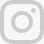

In [329]:
import urllib.request
# with urllib.request.urlopen(post_url) as response:
#    html = response.read()

post_url = 'https://api.instagram.com/oembed?url=' + df.iloc[0]['link_to_post'] + '/'
response = urllib.request.urlopen(post_url)
html = json.load(response)   
print(html['html'])

In [325]:
# for i in range(len(df[0:5])):
#     print(df.iloc[i]['link_to_post'])
    
post_urls = []
for i in range(len(df[0:5])):
    post_urls.append(df.iloc[i]['link_to_post'][i][-11:])
post_urls


['h', 't', 't', 'p', 's']

In [328]:
df.iloc[0]['link_to_post']

'https://www.instagram.com/p/BeB56DIFm_j'

In [330]:
link_htmls = []
for i in range(len(df[0:5])):
    post_url = 'https://api.instagram.com/oembed?url=' + df.iloc[i]['link_to_post'] + '/'
    response = urllib.request.urlopen(post_url)
    html = json.load(response)
    link_htmls.append(html['html'])
len(link_htmls)


5

['<blockquote class="instagram-media" data-instgrm-captioned data-instgrm-permalink="https://www.instagram.com/p/BeB56DIFm_j/" data-instgrm-version="8" style=" background:#FFF; border:0; border-radius:3px; box-shadow:0 0 1px 0 rgba(0,0,0,0.5),0 1px 10px 0 rgba(0,0,0,0.15); margin: 1px; max-width:658px; padding:0; width:99.375%; width:-webkit-calc(100% - 2px); width:calc(100% - 2px);"><div style="padding:8px;"> <div style=" background:#F8F8F8; line-height:0; margin-top:40px; padding:50.0% 0; text-align:center; width:100%;"> <div style=" background:url(); display:block; height:44px; margin:0 auto -44px; position:relative; top:-22px; width:44px;"></div></div> <p style=" margin:8px 0 0 0; padding:0 4px;"> <a href="https://www.instagram.com/p/BeB56DIFm_j/" style=" color:#000; font-family:Arial,sans-serif; font-size:14px; font-style:normal; font-weight:normal; line-height:17px; text-decoration:none; word-wrap:break-word;" target="_blank">Incredible placement and execution on this #snake #tat
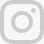
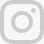
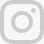

In [331]:
link_htmls[0:3]


0
BeB56DIFm_j
<blockquote class="instagram-media" data-instgrm-captioned data-instgrm-permalink="https://www.instagram.com/p/BeB56DIFm_j/" data-instgrm-version="8" style=" background:#FFF; border:0; border-radius:3px; box-shadow:0 0 1px 0 rgba(0,0,0,0.5),0 1px 10px 0 rgba(0,0,0,0.15); margin: 1px; max-width:658px; padding:0; width:99.375%; width:-webkit-calc(100% - 2px); width:calc(100% - 2px);"><div style="padding:8px;"> <div style=" background:#F8F8F8; line-height:0; margin-top:40px; padding:50.0% 0; text-align:center; width:100%;"> <div style=" background:url(); display:block; height:44px; margin:0 auto -44px; position:relative; top:-22px; width:44px;"></div></div> <p style=" margin:8px 0 0 0; padding:0 4px;"> <a href="https://www.instagram.com/p/BeB56DIFm_j/" style=" color:#000; font-family:Arial,sans-serif; font-size:14px; font-style:normal; font-weight:normal; line-height:17px; text-decoration:none; word-wrap:break-word;" target="_blank">Incredible placement and execution on thi
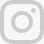
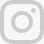
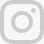
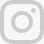


4
BdwDISqH76O
<blockquote class="instagram-media" data-instgrm-captioned data-instgrm-permalink="https://www.instagram.com/p/BdwDISqH76O/" data-instgrm-version="8" style=" background:#FFF; border:0; border-radius:3px; box-shadow:0 0 1px 0 rgba(0,0,0,0.5),0 1px 10px 0 rgba(0,0,0,0.15); margin: 1px; max-width:658px; padding:0; width:99.375%; width:-webkit-calc(100% - 2px); width:calc(100% - 2px);"><div style="padding:8px;"> <div style=" background:#F8F8F8; line-height:0; margin-top:40px; padding:50.0% 0; text-align:center; width:100%;"> <div style=" background:url(); display:block; height:44px; margin:0 auto -44px; position:relative; top:-22px; width:44px;"></div></div> <p style=" margin:8px 0 0 0; padding:0 4px;"> <a href="https://www.instagram.com/p/BdwDISqH76O/" style=" color:#000; font-family:Arial,sans-serif; font-size:14px; font-style:normal; font-weight:normal; line-height:17px; text-decoration:none; word-wrap:break-word;" target="_blank">The feeling when you’re nearing the end o
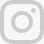
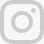
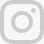
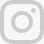


8
Bd__2IQApxy
<blockquote class="instagram-media" data-instgrm-captioned data-instgrm-permalink="https://www.instagram.com/p/Bd__2IQApxy/" data-instgrm-version="8" style=" background:#FFF; border:0; border-radius:3px; box-shadow:0 0 1px 0 rgba(0,0,0,0.5),0 1px 10px 0 rgba(0,0,0,0.15); margin: 1px; max-width:658px; padding:0; width:99.375%; width:-webkit-calc(100% - 2px); width:calc(100% - 2px);"><div style="padding:8px;"> <div style=" background:#F8F8F8; line-height:0; margin-top:40px; padding:50.0% 0; text-align:center; width:100%;"> <div style=" background:url(); display:block; height:44px; margin:0 auto -44px; position:relative; top:-22px; width:44px;"></div></div> <p style=" margin:8px 0 0 0; padding:0 4px;"> <a href="https://www.instagram.com/p/Bd__2IQApxy/" style=" color:#000; font-family:Arial,sans-serif; font-size:14px; font-style:normal; font-weight:normal; line-height:17px; text-decoration:none; word-wrap:break-word;" target="_blank">I turned 40 today. In September I marked 
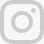
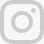
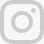
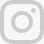


12
Bd6ZUDQH7Wr
<blockquote class="instagram-media" data-instgrm-captioned data-instgrm-permalink="https://www.instagram.com/p/Bd6ZUDQH7Wr/" data-instgrm-version="8" style=" background:#FFF; border:0; border-radius:3px; box-shadow:0 0 1px 0 rgba(0,0,0,0.5),0 1px 10px 0 rgba(0,0,0,0.15); margin: 1px; max-width:658px; padding:0; width:99.375%; width:-webkit-calc(100% - 2px); width:calc(100% - 2px);"><div style="padding:8px;"> <div style=" background:#F8F8F8; line-height:0; margin-top:40px; padding:50% 0; text-align:center; width:100%;"> <div style=" background:url(); display:block; height:44px; margin:0 auto -44px; position:relative; top:-22px; width:44px;"></div></div> <p style=" margin:8px 0 0 0; padding:0 4px;"> <a href="https://www.instagram.com/p/Bd6ZUDQH7Wr/" style=" color:#000; font-family:Arial,sans-serif; font-size:14px; font-style:normal; font-weight:normal; line-height:17px; text-decoration:none; word-wrap:break-word;" target="_blank">Break the rules and go face first. #maketa
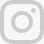
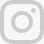
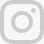
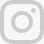


16
BeE3QwLnHib
<blockquote class="instagram-media" data-instgrm-captioned data-instgrm-permalink="https://www.instagram.com/p/BeE3QwLnHib/" data-instgrm-version="8" style=" background:#FFF; border:0; border-radius:3px; box-shadow:0 0 1px 0 rgba(0,0,0,0.5),0 1px 10px 0 rgba(0,0,0,0.15); margin: 1px; max-width:658px; padding:0; width:99.375%; width:-webkit-calc(100% - 2px); width:calc(100% - 2px);"><div style="padding:8px;"> <div style=" background:#F8F8F8; line-height:0; margin-top:40px; padding:50.0% 0; text-align:center; width:100%;"> <div style=" background:url(); display:block; height:44px; margin:0 auto -44px; position:relative; top:-22px; width:44px;"></div></div> <p style=" margin:8px 0 0 0; padding:0 4px;"> <a href="https://www.instagram.com/p/BeE3QwLnHib/" style=" color:#000; font-family:Arial,sans-serif; font-size:14px; font-style:normal; font-weight:normal; line-height:17px; text-decoration:none; word-wrap:break-word;" target="_blank">Kill Gorilla tattoo by @zanderthorn at O
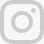
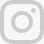
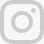
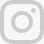


20
Bd7_iamFIbr
<blockquote class="instagram-media" data-instgrm-captioned data-instgrm-permalink="https://www.instagram.com/p/Bd7_iamFIbr/" data-instgrm-version="8" style=" background:#FFF; border:0; border-radius:3px; box-shadow:0 0 1px 0 rgba(0,0,0,0.5),0 1px 10px 0 rgba(0,0,0,0.15); margin: 1px; max-width:658px; padding:0; width:99.375%; width:-webkit-calc(100% - 2px); width:calc(100% - 2px);"><div style="padding:8px;"> <div style=" background:#F8F8F8; line-height:0; margin-top:40px; padding:50.0% 0; text-align:center; width:100%;"> <div style=" background:url(); display:block; height:44px; margin:0 auto -44px; position:relative; top:-22px; width:44px;"></div></div> <p style=" margin:8px 0 0 0; padding:0 4px;"> <a href="https://www.instagram.com/p/Bd7_iamFIbr/" style=" color:#000; font-family:Arial,sans-serif; font-size:14px; font-style:normal; font-weight:normal; line-height:17px; text-decoration:none; word-wrap:break-word;" target="_blank">Great tattoo by @da_ink ➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖
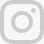
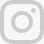
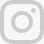
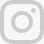


24
BdtOj3FAkyO
<blockquote class="instagram-media" data-instgrm-captioned data-instgrm-permalink="https://www.instagram.com/p/BdtOj3FAkyO/" data-instgrm-version="8" style=" background:#FFF; border:0; border-radius:3px; box-shadow:0 0 1px 0 rgba(0,0,0,0.5),0 1px 10px 0 rgba(0,0,0,0.15); margin: 1px; max-width:658px; padding:0; width:99.375%; width:-webkit-calc(100% - 2px); width:calc(100% - 2px);"><div style="padding:8px;"> <div style=" background:#F8F8F8; line-height:0; margin-top:40px; padding:50.0% 0; text-align:center; width:100%;"> <div style=" background:url(); display:block; height:44px; margin:0 auto -44px; position:relative; top:-22px; width:44px;"></div></div> <p style=" margin:8px 0 0 0; padding:0 4px;"> <a href="https://www.instagram.com/p/BdtOj3FAkyO/" style=" color:#000; font-family:Arial,sans-serif; font-size:14px; font-style:normal; font-weight:normal; line-height:17px; text-decoration:none; word-wrap:break-word;" target="_blank">Meet Ralphy ☺️ 🔴Thank you for viewing.  
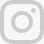
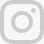
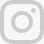
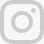


28
Bd1OlvCHBxq
<blockquote class="instagram-media" data-instgrm-captioned data-instgrm-permalink="https://www.instagram.com/p/Bd1OlvCHBxq/" data-instgrm-version="8" style=" background:#FFF; border:0; border-radius:3px; box-shadow:0 0 1px 0 rgba(0,0,0,0.5),0 1px 10px 0 rgba(0,0,0,0.15); margin: 1px; max-width:658px; padding:0; width:99.375%; width:-webkit-calc(100% - 2px); width:calc(100% - 2px);"><div style="padding:8px;"> <div style=" background:#F8F8F8; line-height:0; margin-top:40px; padding:52.824074074074076% 0; text-align:center; width:100%;"> <div style=" background:url(); display:block; height:44px; margin:0 auto -44px; position:relative; top:-22px; width:44px;"></div></div> <p style=" margin:8px 0 0 0; padding:0 4px;"> <a href="https://www.instagram.com/p/Bd1OlvCHBxq/" style=" color:#000; font-family:Arial,sans-serif; font-size:14px; font-style:normal; font-weight:normal; line-height:17px; text-decoration:none; word-wrap:break-word;" target="_blank">Loggerhead Shrikes on the 
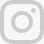
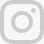
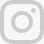

IndexError: list index out of range

In [267]:
for i in range(35):
    cur_shortcode = shortcodes[i]
    post_url = 'https://api.instagram.com/oembed?url=http://instagr.am/p/' + shortcodes[i] + '/'
    response = urllib.request.urlopen(post_url)
    html = json.load(response)   
    print()
    print(i)
    print(cur_shortcode)
    print(html['html'])

'<blockquote class="instagram-media" data-instgrm-captioned data-instgrm-permalink="https://www.instagram.com/p/fA9uwTtkSN/" data-instgrm-version="8" style=" background:#FFF; border:0; border-radius:3px; box-shadow:0 0 1px 0 rgba(0,0,0,0.5),0 1px 10px 0 rgba(0,0,0,0.15); margin: 1px; max-width:658px; padding:0; width:99.375%; width:-webkit-calc(100% - 2px); width:calc(100% - 2px);"><div style="padding:8px;"> <div style=" background:#F8F8F8; line-height:0; margin-top:40px; padding:50% 0; text-align:center; width:100%;"> <div style=" background:url(); display:block; height:44px; margin:0 auto -44px; position:relative; top:-22px; width:44px;"></div></div> <p style=" margin:8px 0 0 0; padding:0 4px;"> <a href="https://www.instagram.com/p/fA9uwTtkSN/" style=" color:#000; font-family:Arial,sans-serif; font-size:14px; font-style:normal; font-weight:normal; line-height:17px; text-decoration:none; word-wrap:break-word;" target="_blank">Wii Gato (Lipe Sleep)</a></p> <p style=" color:#c9c8cd; fon
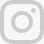

In [167]:
html_dict = json.loads(html)
html_dict['html']

In [165]:
test_dict = {'a':1,'b':2,'c':3}
test_dict['a']

1

<html><head></head><body><blockquote class="instagram-media" data-instgrm-captioned="" data-instgrm-permalink="https://www.instagram.com/p/fA9uwTtkSN/" data-instgrm-version="8" style=" background:#FFF; border:0; border-radius:3px; box-shadow:0 0 1px 0 rgba(0,0,0,0.5),0 1px 10px 0 rgba(0,0,0,0.15); margin: 1px; max-width:658px; padding:0; width:99.375%; width:-webkit-calc(100% - 2px); width:calc(100% - 2px);"><div style="padding:8px;"> <div style=" background:#F8F8F8; line-height:0; margin-top:40px; padding:50% 0; text-align:center; width:100%;"> <div style=" background:url(); display:block; height:44px; margin:0 auto -44px; position:relative; top:-22px; width:44px;"></div></div> <p style=" margin:8px 0 0 0; padding:0 4px;"> <a href="https://www.instagram.com/p/fA9uwTtkSN/" style=" color:#000; font-family:Arial,sans-serif; font-size:14px; font-style:normal; font-weight:normal; line-height:17px; text-decoration:none; word-wrap:break-word;" target="_blank">Wii Gato (Lipe Sleep)</a></p> <p
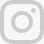

In [72]:
soup = BeautifulSoup(html_dict['html'], "html5lib")
soup

In [62]:
r = requests.get(post_url)

<Response [200]>

<html><head></head><body>{"version": "1.0", "title": "Wii Gato (Lipe Sleep)", "author_name": "diegoquinteiro", "author_url": "https://www.instagram.com/diegoquinteiro", "author_id": 9538472, "media_id": "558717847597368461_9538472", "provider_name": "Instagram", "provider_url": "https://www.instagram.com", "type": "rich", "width": 658, "height": null, "html": "\u003cblockquote class=\"instagram-media\" data-instgrm-captioned data-instgrm-permalink=\"https://www.instagram.com/p/fA9uwTtkSN/\" data-instgrm-version=\"8\" style=\" background:#FFF; border:0; border-radius:3px; box-shadow:0 0 1px 0 rgba(0,0,0,0.5),0 1px 10px 0 rgba(0,0,0,0.15); margin: 1px; max-width:658px; padding:0; width:99.375%; width:-webkit-calc(100% - 2px); width:calc(100% - 2px);\"\u003e\u003cdiv style=\"padding:8px;\"\u003e \u003cdiv style=\" background:#F8F8F8; line-height:0; margin-top:40px; padding:50% 0; text-align:center; width:100%;\"\u003e \u003cdiv style=\" background:url(); display:block; height:44px; margin
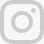

In [56]:
soup = BeautifulSoup(html, "html5lib")
soup